# Mask RCNN inference


# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

from copy import copy
import cv2
from skimage.morphology import skeletonize

import time
import datetime
import pickle

# This is needed to display the images.
%matplotlib inline

from tensorflow.models.research.object_detection.utils import label_map_util
from tensorflow.models.research.object_detection.utils import visualization_utils as vis_util

/Users/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/daniel/anaconda3/lib/python3.6/site-packages/tensorflow/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/daniel/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  Fi

# Model preparation 

In [2]:
# Path to frozen detection graph.
MODEL_NAME = 'resnet_50_atrous/fine_tuned_model_100k_poisson'
PATH_TO_CKPT = os.path.join('./downloaded_models', MODEL_NAME, 'frozen_inference_graph.pb')

## Load a (frozen) Tensorflow model into memory.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map


In [4]:
PATH_TO_LABELS = '/Users/daniel/Documents/UCL/Project/Code/tensorflow_Mask_RCNN/data/worm_label_map.pbtxt'
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


## Helper code

In [5]:
# def load_image_into_numpy_array(image):
#   (im_width, im_height) = image.size
#   return np.array(image.getdata()).reshape(
#       (im_height, im_width, -1)).astype(np.uint8)[:,:,:3]

In [6]:
from utility_functions import load_image_into_numpy_array
from utility_functions import run_inference_for_single_image

In [7]:
# def run_inference_for_single_image(image, graph):
#   with graph.as_default():
#     with tf.Session() as sess:
#       # Get handles to input and output tensors
#       ops = tf.get_default_graph().get_operations()
#       all_tensor_names = {output.name for op in ops for output in op.outputs}
#       tensor_dict = {}
#       for key in [
#           'num_detections', 'detection_boxes', 'detection_scores',
#           'detection_classes', 'detection_masks'
#       ]:
#         tensor_name = key + ':0'
#         if tensor_name in all_tensor_names:
#           tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
#               tensor_name)
#       if 'detection_masks' in tensor_dict:
#         # The following processing is only for single image
#         detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
#         detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
#         # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
#         real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
#         detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
#         detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
#         detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
#             detection_masks, detection_boxes, image.shape[0], image.shape[1])
#         detection_masks_reframed = tf.cast(
#             tf.greater(detection_masks_reframed, 0.5), tf.uint8)
#         # Follow the convention by adding back the batch dimension
#         tensor_dict['detection_masks'] = tf.expand_dims(
#             detection_masks_reframed, 0)
#       image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

#       # Run inference
#       output_dict = sess.run(tensor_dict,
#                              feed_dict={image_tensor: np.expand_dims(image, 0)})

#       # all outputs are float32 numpy arrays, so convert types as appropriate
#       output_dict['num_detections'] = int(output_dict['num_detections'][0])
#       output_dict['detection_classes'] = output_dict[
#           'detection_classes'][0].astype(np.uint8)
#       output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
#       output_dict['detection_scores'] = output_dict['detection_scores'][0]
#       if 'detection_masks' in output_dict:
#         output_dict['detection_masks'] = output_dict['detection_masks'][0]
#   return output_dict

# Load images for inference

In [8]:
NUM_IMAGES = 5

DATASET_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/fullsize_collated_dataset/'
datasets = [f for f in os.listdir(DATASET_DIR) if not f.startswith('.')]
print(datasets)

['JU2234_worms10_food1-10_Set1_Pos4_Ch3_20102017_125033', 'N2_worms10_CSCD068947_1_Set1_Pos4_Ch4_08082017_210418', 'CX11271_worms10_food1-10_Set1_Pos4_Ch4_19052017_113042', 'JU2587_worms10_food1-10_Set1_Pos4_Ch1_20102017_125044', 'NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012', 'JU2578_worms10_food1-10_Set1_Pos4_Ch4_20102017_125033', 'VC2010_worms10_food1-10_Set1_Pos4_Ch6_20122017_150107', 'ED3049_worms10_food1-10_Set6_Pos5_Ch4_19052017_151021', 'N2_worms10_CSCD068947_10_Set2_Pos5_Ch1_08082017_212337', 'N2_worms10_food1-10_Set1_Pos4_Ch5_20102017_125024', 'JU360_worms10_food1-10_Set6_Pos5_Ch6_19052017_151012', 'CB4856_worms10_food1-10_Set1_Pos4_Ch2_20102017_125044']


In [9]:
dataset = datasets[4]
print("Running inference on dataset {}".format(dataset))

PATH_TO_TEST_IMAGES_DIR = os.path.join(DATASET_DIR, dataset)
# PATH_TO_TEST_IMAGES_DIR = '/Users/daniel/Documents/UCL/Project/Data/annotation-data/fullsize_collated_dataset/NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012/'


FNAMES = [f for f in os.listdir(PATH_TO_TEST_IMAGES_DIR) if not f.startswith('.')]
FNAMES = sorted(FNAMES, key=int)[:NUM_IMAGES]
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(i,i)) for i in FNAMES] # np.random.choice(len(FNAMES), size=NUM_IMAGES, replace=False)]

# Size of output images.
IMAGE_SIZE = (40,40)

Running inference on dataset NIC199_worms10_food1-10_Set7_Pos4_Ch4_19052017_153012


# Detection

Inference for one image: 65.597588s


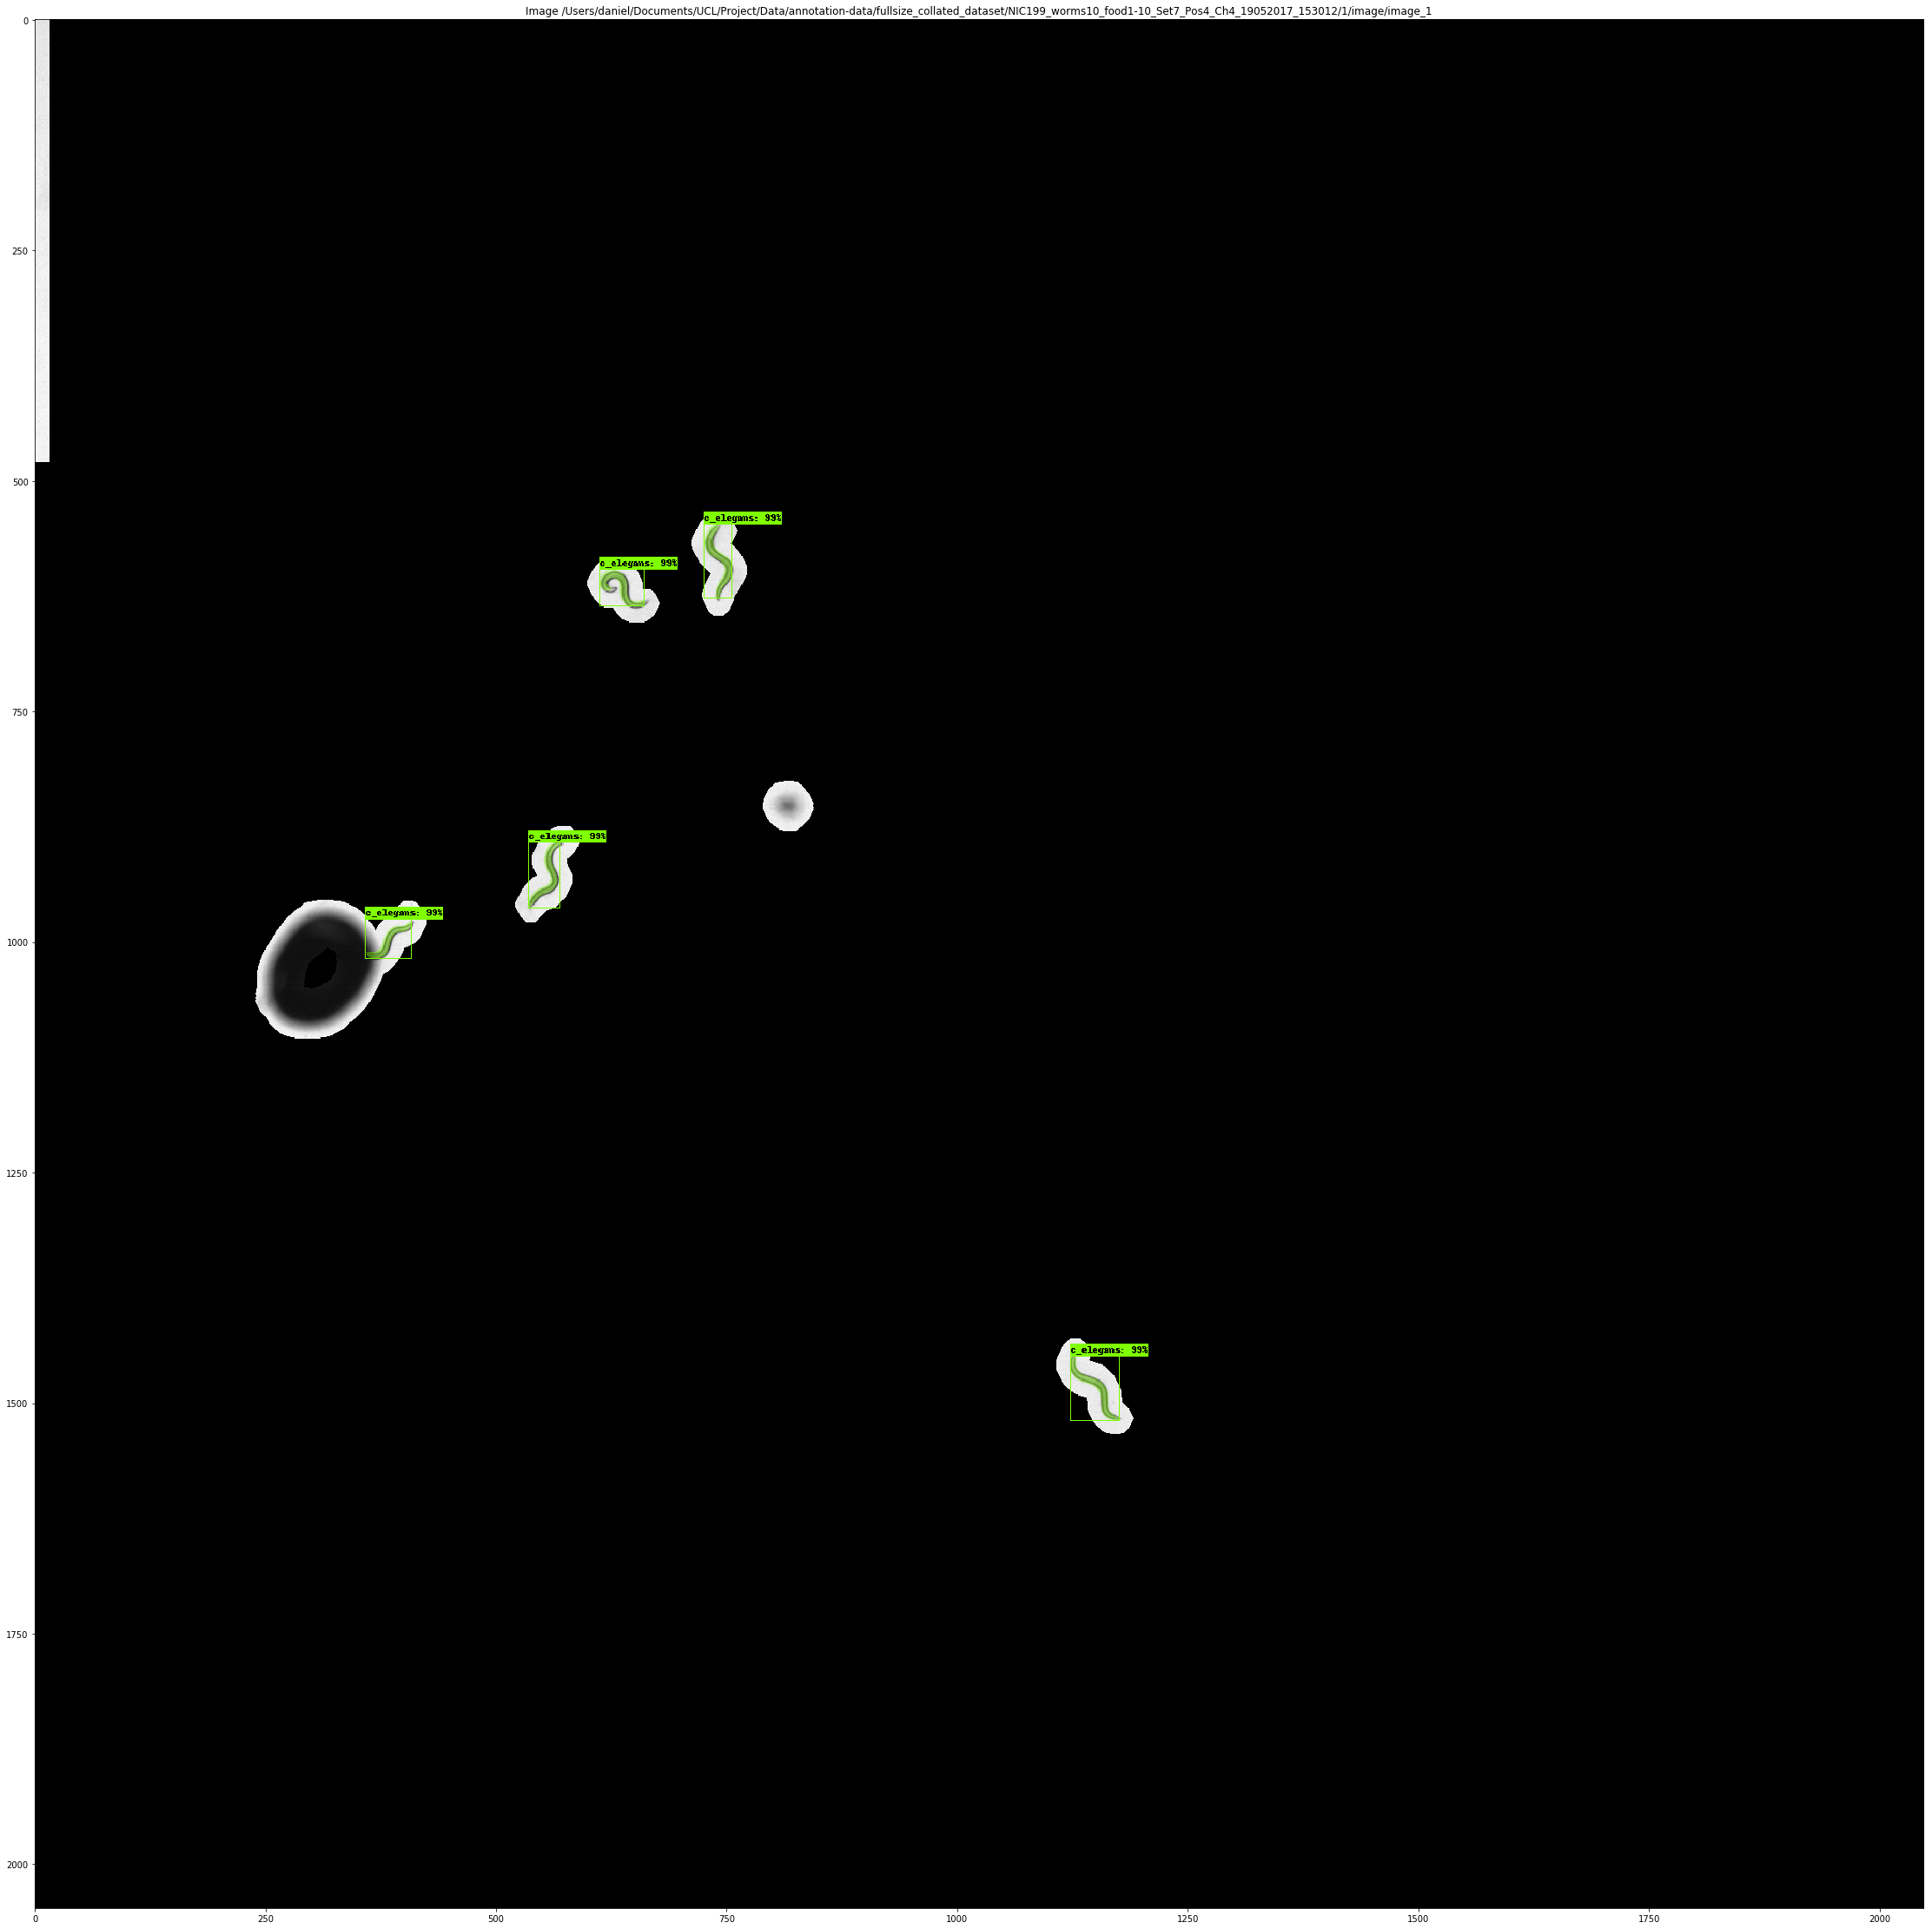

KeyboardInterrupt: 

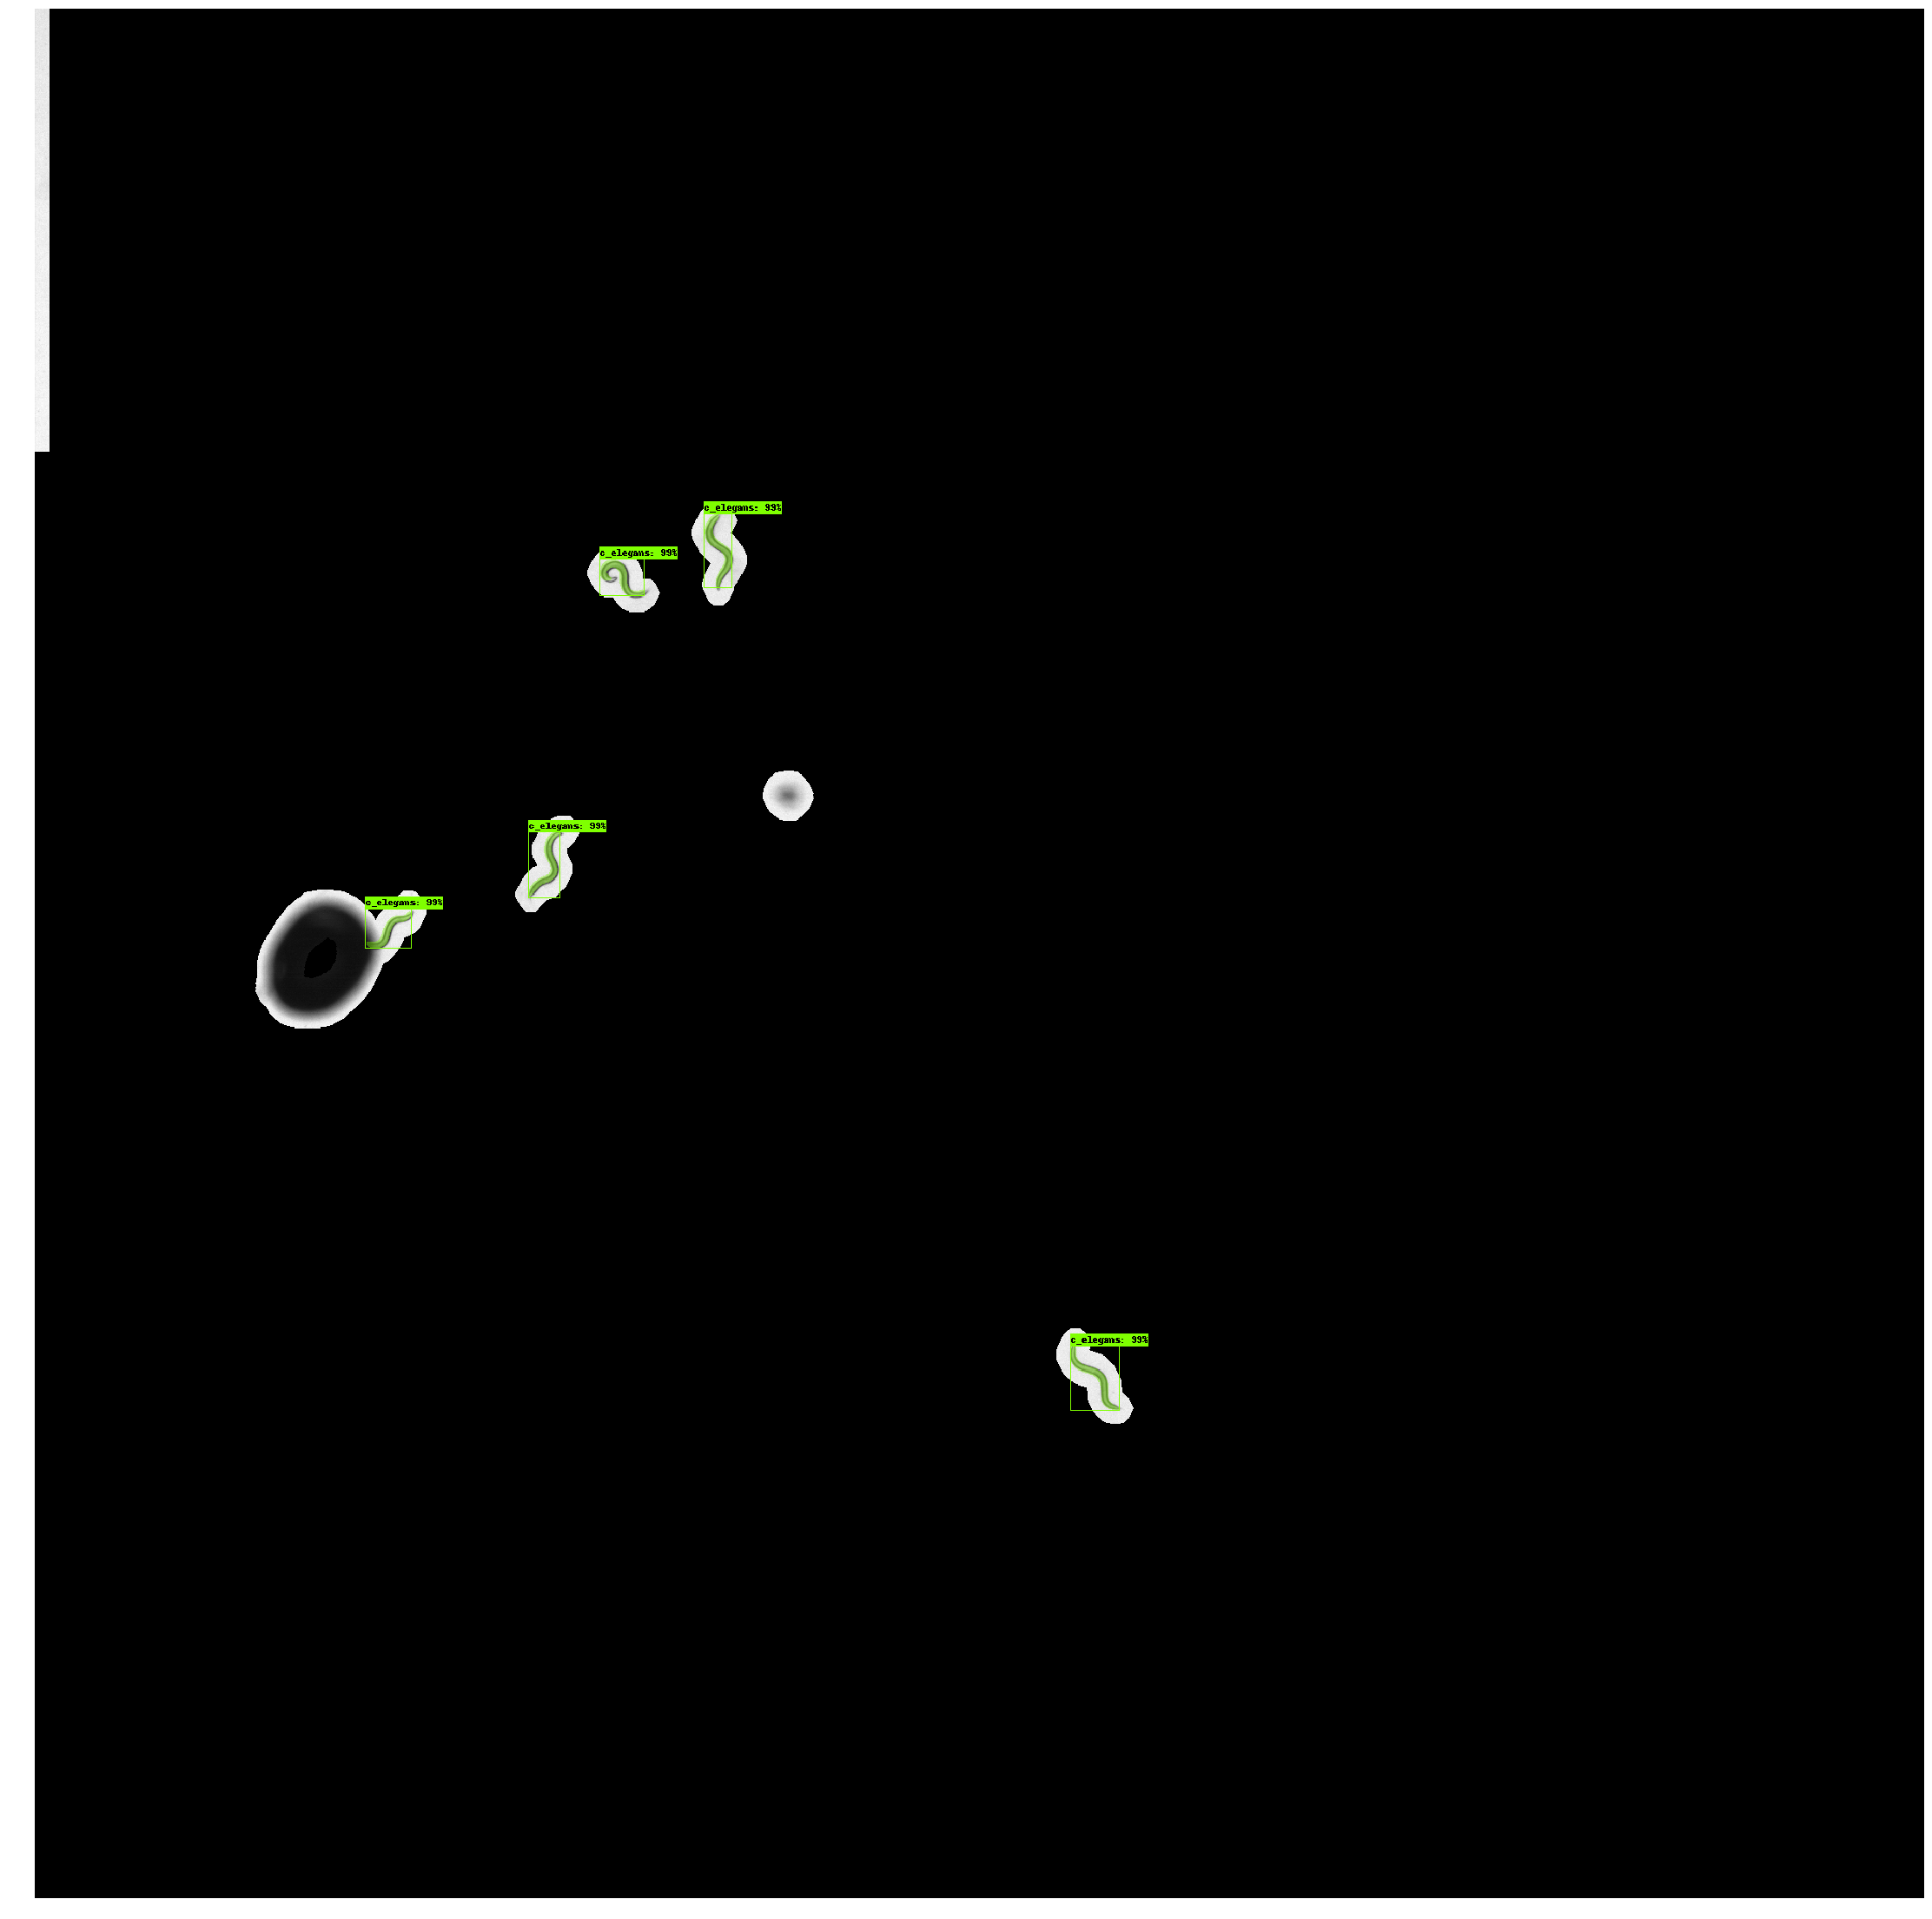

In [10]:
output_dicts_list = []
inference_times = []

visualise_outputs = False
save_anns_to_file = False
save_overlays_to_file = True


for fName in FNAMES:
    
    image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fName,fName))

    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    
    start = datetime.datetime.now()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    end = datetime.datetime.now()
    elapsed = end - start
    print("Inference for one image: {}.{}s".format(elapsed.seconds,round(elapsed.microseconds,2))) 
    inference_times.append(elapsed.seconds)

    if visualise_outputs:
        vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=1)
        plt.figure(figsize=IMAGE_SIZE)
        plt.title("Image {}".format(image_path[:-4]))
        plt.imshow(image_np)
        plt.show()
        plt.close()

    # Keeping only worms which scored > 0.5
    found_worms = np.where(output_dict['detection_scores'] > 0.5)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][found_worms]
    output_dict['detection_classes'] = output_dict['detection_classes'][found_worms]
    output_dict['detection_scores'] = output_dict['detection_scores'][found_worms]
    output_dict['detection_masks'] = output_dict['detection_masks'][found_worms]
    output_dict['skeletons'] = []
    output_dict['frame_num'] = fName
    
    for m in output_dict['detection_masks']:
        output_dict['skeletons'].append(skeletonize(m).astype(np.uint8))

    
    OUTPUT_DIR_PATH = os.path.join('./data/inference_outputs', MODEL_NAME, dataset)

    
    if save_anns_to_file:
        #Save outputs to Pickle file
        os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'annotations'), exist_ok=True)
        ANNS_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH,'annotations', fName) + '.pickle'
        with open(ANNS_OUTPUT_PATH, 'wb') as fp:
            pickle.dump(output_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
    if save_overlays_to_file:
        #save image with annotations overlaid to file
        os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
        IMG_OUTPUT_PATH = os.path.join(OUTPUT_DIR_PATH,'images', fName) + '.png'
        
        plt.figure(figsize=IMAGE_SIZE)
        
        # If the image ahsn't already been visualised, we need 
        # to add the masks and boxes now
        if not visualise_outputs:
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              output_dict['detection_boxes'],
              output_dict['detection_classes'],
              output_dict['detection_scores'],
              category_index,
              instance_masks=output_dict.get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=1)
            
        plt.imshow(image_np)
        plt.axis('off')
        plt.savefig(fname=IMG_OUTPUT_PATH, bbox_inches='tight', pad_inches=0)
        plt.close
        
    
    output_dicts_list.append(output_dict)
    

In [ ]:
mean_time = round(sum(inference_times) / len(inference_times), 2)
print("Average inference time for {} images: {}s".format(NUM_IMAGES, mean_time))

# Skeletonisation


Visualise the last image and its skeletons as a sense-check

In [ ]:
skeletons = np.array(output_dicts_list[-1]['skeletons'])

In [ ]:
plt.figure(figsize=(80,80))

plt.subplot(1,2,1)
plt.imshow(image_np)

plt.subplot(1,2,2)
plt.imshow(np.sum(skeletons, axis=0))

plt.show()
plt.close()

# Tracking using SORT

In [ ]:
from sort import sort
import matplotlib.patches as patches

In [ ]:
display = True
verbose = False
colours = np.random.rand(32,3)



#create instance of SORT
worm_tracker = sort.Sort(max_age=5, min_hits=0) 

# get detections
all_detections = [np.hstack((i['detection_boxes']*2048, np.expand_dims(i['detection_scores'],1))) for i in output_dicts_list]


for frame in range(len(all_detections)):
        
    
    # update SORT
    detections = all_detections[frame]

    
    ids = worm_tracker.update(detections)
    
    if verbose:
        print('Detections: {}'.format(detections))
        print('ids shape: {}'.format(ids.shape))
        print('ids: {}'.format(ids))
    
    print("Worm IDs: {}".format(sorted(ids[:,-1], key=int)))
    
    if(display):
        
        fName = FNAMES[frame]
    
        image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}/image/image_{}.png'.format(fName,fName))

        img = Image.open(image_path)
        img_np = load_image_into_numpy_array(img)
        
        fig = plt.figure(figsize=(IMAGE_SIZE))
        
        
        ax = fig.add_subplot(121, aspect='equal')
        ax.imshow(img_np)

        for d in ids:
            d = d.astype(np.int32)
            ax.add_patch(patches.Rectangle((d[1],d[0]),d[3]-d[1],d[2]-d[0],
                                           fill=False,
                                           lw=3,
                                           ec=colours[d[4]%32,:]))
            ax.set_adjustable('box-forced')
            plt.text(d[1],d[0],d[-1],color='w')
        
        ax_2 = fig.add_subplot(122, aspect='equal')
        vis_util.visualize_boxes_and_labels_on_image_array(
              img_np,
              output_dicts_list[frame]['detection_boxes'],
              output_dicts_list[frame]['detection_classes'],
              output_dicts_list[frame]['detection_scores'],
              category_index,
              instance_masks=output_dicts_list[frame].get('detection_masks'),
              use_normalized_coordinates=True,
              line_thickness=2)
        ax_2.imshow(img_np)
        
        plt.legend()
        plt.show()
        plt.close
